In [ ]:
# !python -m spacy download en_core_web_sm

In [ ]:
# !python -m spacy download en_core_web_lg

# Loading Dataset and NLP libraries 

In [116]:
#Importing the necessary librarires
import os
import string
import math
import nltk
import scipy
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



import spacy
import pickle
from text_preprocessing import preprocess_text
from text_preprocessing import to_lower, expand_contraction, remove_number, \
        remove_special_character,normalize_unicode,remove_punctuation,remove_stopword,check_spelling



import fasttext
from tqdm import tqdm
from wordcloud import WordCloud
from gensim.models import Word2Vec
from multiprocessing import Pool

from scipy.stats import loguniform
from scipy.stats import randint

from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import word_tokenize,sent_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from scikitplot.metrics import plot_roc_curve as auc_roc
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, \
    roc_auc_score, roc_curve, precision_score, recall_score

from xgboost import XGBClassifier

from IPython.display import display

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

In [117]:

tqdm.pandas()
load_model = spacy.load('en_core_web_sm', disable = ['parser','ner'])

# Import dataset

In [118]:
#Importing the dataset

df = pd.read_csv('movie.csv', header=0)
target = 'label'
df.reset_index(drop=True, inplace=True)
original_df = df.copy(deep=True)
display(df.head(6))

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1
5,A terrible movie as everyone has said. What ma...,0



Inference: The Datset consists of 2 features & 40000 samples.


In [119]:
#Checking the dtypes of all the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [120]:
df.shape

(40000, 2)

In [121]:
df.label.value_counts()

0    20019
1    19981
Name: label, dtype: int64

In [122]:
#Checking the stats of all the columns

display(df.describe(include='all'))

,text,label
count,40000,40000.000000
unique,39723,NaN
top,"Hilarious, clean, light-hearted, and quote-wor...",NaN
freq,4,NaN
mean,NaN,0.499525
std,NaN,0.500006
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,0.000000
75%,NaN,1.000000


## Empty cells

In [123]:
#Check for empty elements

print(df.isnull().sum())
print('\n\033[1mInference:\033[0m The dataset doesn\'t have any null elements')

text     0
label    0
dtype: int64

Inference: The dataset doesn't have any null elements


## Remove duplicate

In [124]:
#Removal of any Duplicate rows (if any)

counter = 0
r,c = original_df.shape

df1 = df.drop_duplicates()
df1.reset_index(drop=True, inplace=True)

if df1.shape==(r,c):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {r-df1.shape[0]}')


Inference: Number of duplicates dropped/fixed ---> 277


## Text Pre-processing

In [125]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

In [126]:
# Pre Processing the text to  remove unnecessary content
# e.g. <br > <br /> <p></p>

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
df1['text']=df1['text'].apply(denoise_text)

In [127]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
df1['text']=df1['text'].apply(remove_special_characters)

## Stemming and Stop word removal

In [128]:
#Stemming the text

from nltk.stem import SnowballStemmer


def simple_stemmer(text):
    snowball = SnowballStemmer(language='english')
    text= ' '.join([snowball.stem(word) for word in text.split()])
    return text
#Apply function on review column
df1['text']=df1['text'].apply(simple_stemmer)

# Stop word remove

In [129]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column

df1['text'] =df1['text'].apply(remove_stopwords)

{'itself', 'down', 'there', 'with', 'through', 'against', 'and', 'mightn', 'am', "hadn't", 'for', 'how', "shan't", 'theirs', 'the', "mustn't", 'during', 'ain', 'at', 'again', "that'll", 'here', 'if', 'between', "wasn't", 's', 'herself', 've', "don't", 'no', "you'll", 're', 'being', "mightn't", "haven't", 'has', 'hadn', 'you', 'wasn', 'd', "you'd", 'out', 'into', 'only', 'can', 'some', 'be', 'doesn', 'is', 'hasn', "should've", 'an', "couldn't", 'yourselves', 'had', 'did', 'but', 'won', 'who', 'each', 'himself', 'not', 'y', 'this', 'too', 'to', 'few', 'do', 'your', 'their', 'our', 'after', 'below', 'once', 'isn', 'she', 'didn', 'by', "she's", 'all', 'what', 'a', 'have', 't', 'm', 'doing', "you're", 'that', 'because', 'was', 'we', 'him', 'own', 'll', 'where', 'then', 'most', 'having', "shouldn't", 'off', 'over', 'further', 'when', 'about', 'haven', 'which', 'he', 'above', 'more', 'very', 'does', 'hers', 'before', 'from', "aren't", 'now', 'couldn', 'shouldn', "doesn't", 'these', 'don', 'ou

In [130]:
# #Filtering the text

# df = df1.copy()

# def preprocessor(text):
#     text = text.lower()
#     text = ''.join([i for i in text if i in string.ascii_lowercase+' '])
#     text = ' '.join([PorterStemmer().stem(word) for word in text.split()])
#     text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
#     return text

# for i in tqdm(range(df.shape[0])):
#     df.loc[i,'text'] = preprocessor(df['text'][i])


# df.head()

In [131]:
# Save processed dataframe
df1.to_csv('postprocessdata.csv', index=False)

In [132]:
#load a processed data

df = pd.read_csv('postprocessdata.csv')
target = 'label'
df.head(10)

,text,label
0,grew b 1965 watch love thunderbird mate school...,0
1,put movi dvd player sat coke chip expect hope ...,0
2,whi peopl know particular time past like feel ...,0
3,even though great interest biblic movi bore de...,0
4,im die hard dad armi fan noth ever chang got t...,1
5,terribl movi everyon said made laugh cameo app...,0
6,final watch shock movi last night disturb mind...,1
7,caught film azn cabl sound like would good fil...,0
8,may remak 1987 autumn tale eleven year directo...,1
9,super ex girlfriend turn pleasant surpris real...,1


## Tokenization

In [133]:

tfidf=TfidfVectorizer(strip_accents=None,lowercase=False,preprocessor=None,use_idf=True,norm='l2',smooth_idf=True)
tfidf.fit_transform(df.text)

y=df.label.values
x=tfidf.fit_transform(df.text)

In [134]:
df.text

0        grew b 1965 watch love thunderbird mate school...
1        put movi dvd player sat coke chip expect hope ...
2        whi peopl know particular time past like feel ...
3        even though great interest biblic movi bore de...
4        im die hard dad armi fan noth ever chang got t...
                               ...                        
39718    western union someth forgotten classic western...
39719    movi incred piec work explor everi nook cranni...
39720    wife watch movi becaus plan visit sicili strom...
39721    first watch flatlin amaz necessari featur good...
39722    whi would film good onli gross estim 95000000 ...
Name: text, Length: 39723, dtype: object

In [135]:
pickle.dump(tfidf,open('models/tfidfvector_model_2.pkl','wb'))


# Exploratory Data Analysis (EDA)

            Target Variable Distribution           


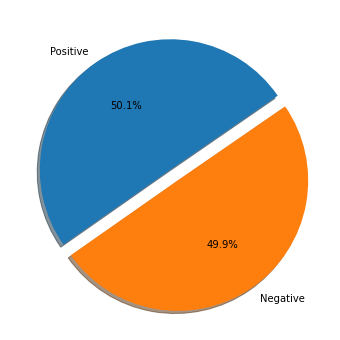

In [136]:
#Let us first analyze the distribution of the target variable

print('\033[1mTarget Variable Distribution'.center(55))
plt.pie(df[target].value_counts(), labels=['Positive','Negative'], counterclock=False, shadow=True, 
        explode=[0,0.1], autopct='%1.1f%%', radius=1, startangle=215)
plt.show()

100%|██████████| 39723/39723 [00:10<00:00, 3891.16it/s]


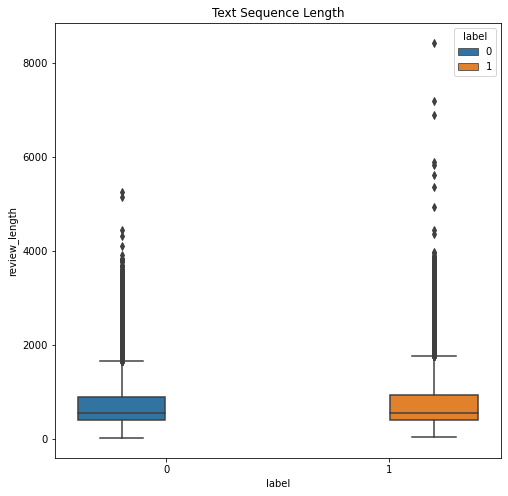

In [137]:
#Visualising the average text sequence length

df2 = df.copy()
df2['review_length'] = 0

for i in tqdm(range(df.shape[0])):
    df2['review_length'][i] = len(df2['text'][i])

plt.figure(figsize=[8,8])
sns.boxplot(x='label',y='review_length', data=df2, hue='label')
plt.title('Text Sequence Length')
plt.show()

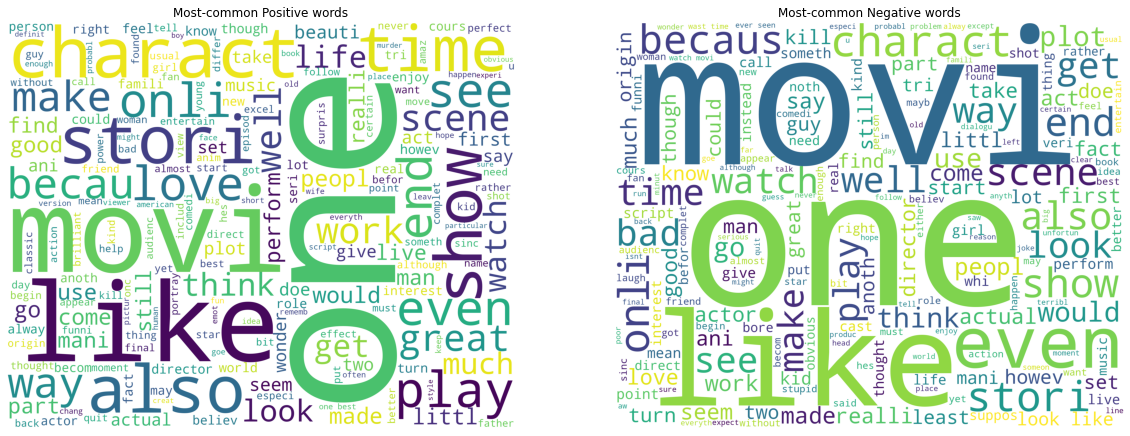

In [138]:
#Visualising the 

positivedata = df[df['label']== 1]
positivedata =positivedata['text']
negdata = df[df['label']== 0]
negdata= negdata['text']

def wordcloud_draw(data, color, s):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split() if(word!='movie' and word!='film')])
    wordcloud = WordCloud(stopwords=stopwords.words('english'),background_color=color,width=2500,height=2000).generate(cleaned_word)
    plt.imshow(wordcloud)
    plt.title(s)
    plt.axis('off')

plt.figure(figsize=[20,10])
plt.subplot(1,2,1)
wordcloud_draw(positivedata,'white','Most-common Positive words')

plt.subplot(1,2,2)
wordcloud_draw(negdata, 'white','Most-common Negative words')
plt.show()

In [139]:
#Plot word number function

def plot_word_number_histogram(textno, textye, textz):
    
    """A function for comparing word counts"""

    fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(18, 12), sharey=True)
    sns.distplot(textno.str.split().map(lambda x: len(x)), ax=axes[0], color='#e74c3c')
    sns.distplot(textye.str.split().map(lambda x: len(x)), ax=axes[1], color='#e74c3c')
    sns.distplot(textz.str.split().map(lambda x: len(x)), ax=axes[2], color='#e74c3c')

    
    axes[0].set_xlabel('Word Count')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('negative')
    axes[1].set_xlabel('Word Count')
    axes[1].set_title('netrual')
    axes[2].set_xlabel('Word Count')
    axes[2].set_title('pozitive')
    
    fig.suptitle('Words Per text', fontsize=24, va='baseline')
    
    fig.tight_layout()

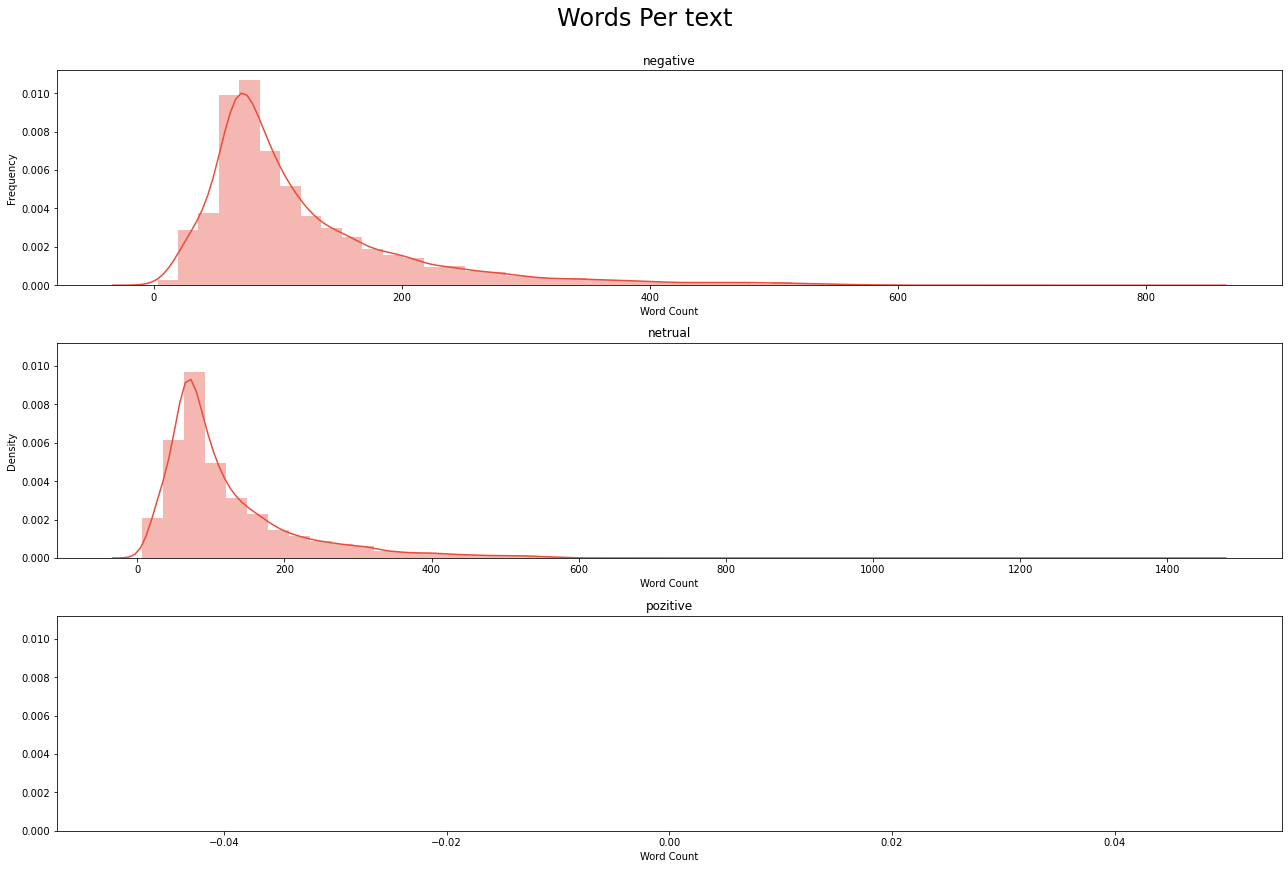

In [140]:
plot_word_number_histogram(df[df['label'] == 0]['text'],
                           df[df['label'] == 1]['text'],
                           df[df['label'] == 2]['text'],
                          )

In [141]:
from matplotlib.ticker import MaxNLocator
from collections import Counter, defaultdict
from matplotlib import gridspec

In [142]:
# valvulate char count for each text
df['char_count'] = df['text'].apply(lambda x: len(str(x)))


def plot_dist3(df, feature, title):
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 )
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    plt.suptitle(f'{title}', fontsize=24)

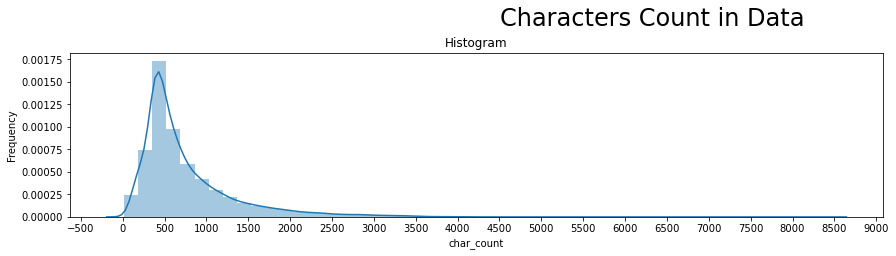

In [143]:
plot_dist3(df, 'char_count',
           'Characters Count in Data')

# 4. Predictive Modeling

In [144]:
#Splitting the data intro training & testing sets

X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=0)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (39723, 2) (39723,) 
Training set  --->  (31778, 155634) (31778,) 
Testing set   --->  (7945, 155634)  (7945,)


In [145]:
#Let us create first create a table to store the results of various models 

Evaluation_Results = pd.DataFrame(np.zeros((4,5)), columns=['Accuracy', 'Precision','Recall','F1-score','AUC-ROC score'])
Evaluation_Results.index=['Logistic Regression (LR)','Decision Tree Classifier (DT)','Random Forest Classifier (RF)','Naïve Bayes Classifier (NB)']
Evaluation_Results

,Accuracy,Precision,Recall,F1-score,AUC-ROC score
Logistic Regression (LR),0.0,0.0,0.0,0.0,0.0
Decision Tree Classifier (DT),0.0,0.0,0.0,0.0,0.0
Random Forest Classifier (RF),0.0,0.0,0.0,0.0,0.0
Naïve Bayes Classifier (NB),0.0,0.0,0.0,0.0,0.0


In [146]:
#Let us define functions to summarise the Prediction's scores .

#Classification Summary Function
def Classification_Summary(pred,pred_prob,i):
    Evaluation_Results.iloc[i]['Accuracy']=round(accuracy_score(Test_Y, pred),3)*100   
    Evaluation_Results.iloc[i]['Precision']=round(precision_score(Test_Y, pred),3)*100 #, average='weighted'
    Evaluation_Results.iloc[i]['Recall']=round(recall_score(Test_Y, pred),3)*100 #, average='weighted'
    Evaluation_Results.iloc[i]['F1-score']=round(f1_score(Test_Y, pred),3)*100 #, average='weighted'
    Evaluation_Results.iloc[i]['AUC-ROC score']=round(roc_auc_score(Test_Y, pred),3)*100 #, multi_class='ovr'
    print('{}{}\033[1m Evaluating {} \033[0m{}{}\n'.format('<'*3,'-'*35,Evaluation_Results.index[i], '-'*35,'>'*3))
    print('Accuracy = {}%'.format(round(accuracy_score(Test_Y, pred),3)*100))
    print('F1 Score = {}%'.format(round(f1_score(Test_Y, pred),3)*100)) #, average='weighted'
    print('\n \033[1mConfusiton Matrix:\033[0m\n',confusion_matrix(Test_Y, pred))
    print('\n\033[1mClassification Report:\033[0m\n',classification_report(Test_Y, pred))
    
    auc_roc(Test_Y, pred_prob, curves=['each_class'])
    plt.show()

#Visualising Function
def AUC_ROC_plot(Test_Y, pred):    
    ref = [0 for _ in range(len(Test_Y))]
    ref_auc = roc_auc_score(Test_Y, ref)
    lr_auc = roc_auc_score(Test_Y, pred)

    ns_fpr, ns_tpr, _ = roc_curve(Test_Y, ref)
    lr_fpr, lr_tpr, _ = roc_curve(Test_Y, pred)

    plt.plot(ns_fpr, ns_tpr, linestyle='--')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='AUC = {}'.format(round(roc_auc_score(Test_Y, pred)*100,2))) 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

# 1. Logistic Regression:

<<<----------------------------------- Evaluating Logistic Regression (LR) ----------------------------------->>>

Accuracy = 88.7%
F1 Score = 88.6%

 Confusiton Matrix:
 [[3570  514]
 [ 382 3479]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.89      4084
           1       0.87      0.90      0.89      3861

    accuracy                           0.89      7945
   macro avg       0.89      0.89      0.89      7945
weighted avg       0.89      0.89      0.89      7945



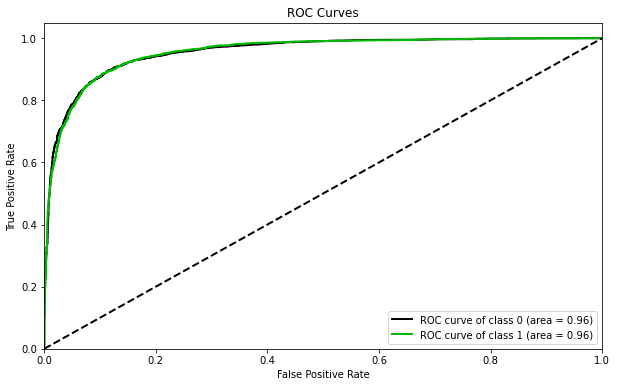

In [147]:
# Building Logistic Regression Classifier

LR_model = LogisticRegression()
LR = LR_model.fit(Train_X, Train_Y)
pred = LR.predict(Test_X)
pred_prob = LR.predict_proba(Test_X)
Classification_Summary(pred,pred_prob,0)

# 2. Decisoin Tree Classfier:

<<<----------------------------------- Evaluating Decision Tree Classifier (DT) ----------------------------------->>>

Accuracy = 71.0%
F1 Score = 70.39999999999999%

 Confusiton Matrix:
 [[2903 1181]
 [1122 2739]]

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.71      0.72      4084
           1       0.70      0.71      0.70      3861

    accuracy                           0.71      7945
   macro avg       0.71      0.71      0.71      7945
weighted avg       0.71      0.71      0.71      7945



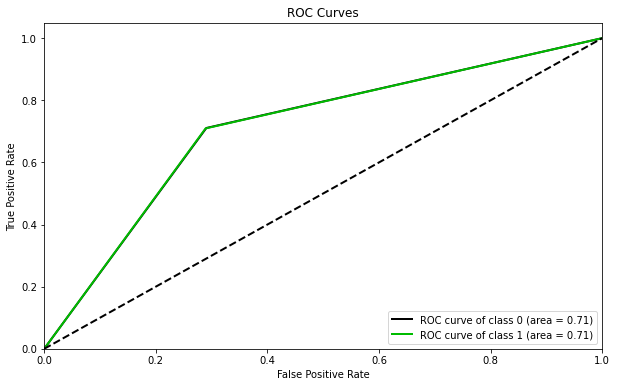

In [148]:
# Building Decision Tree Classifier

DT_model = DecisionTreeClassifier()
DT = DT_model.fit(Train_X, Train_Y)
pred = DT.predict(Test_X)
pred_prob = DT.predict_proba(Test_X)
Classification_Summary(pred,pred_prob,1)

# 3.Random Forest Classfier:

<<<----------------------------------- Evaluating Random Forest Classifier (RF) ----------------------------------->>>

Accuracy = 84.6%
F1 Score = 84.3%

 Confusiton Matrix:
 [[3440  644]
 [ 581 3280]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.84      0.85      4084
           1       0.84      0.85      0.84      3861

    accuracy                           0.85      7945
   macro avg       0.85      0.85      0.85      7945
weighted avg       0.85      0.85      0.85      7945



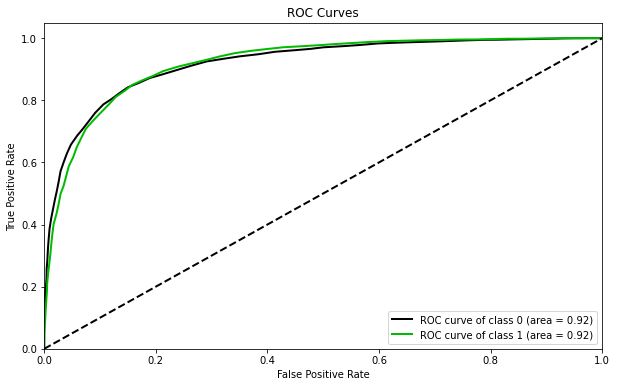

In [149]:
# Building Random Forest Classifier

RF_model = RandomForestClassifier()
RF = RF_model.fit(Train_X, Train_Y)
pred = RF.predict(Test_X)
pred_prob = RF.predict_proba(Test_X)
Classification_Summary(pred,pred_prob,2)

# 4. Naive Bayes Classfier:

<<<----------------------------------- Evaluating Naïve Bayes Classifier (NB) ----------------------------------->>>

Accuracy = 84.5%
F1 Score = 83.6%

 Confusiton Matrix:
 [[3578  506]
 [ 723 3138]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85      4084
           1       0.86      0.81      0.84      3861

    accuracy                           0.85      7945
   macro avg       0.85      0.84      0.84      7945
weighted avg       0.85      0.85      0.85      7945



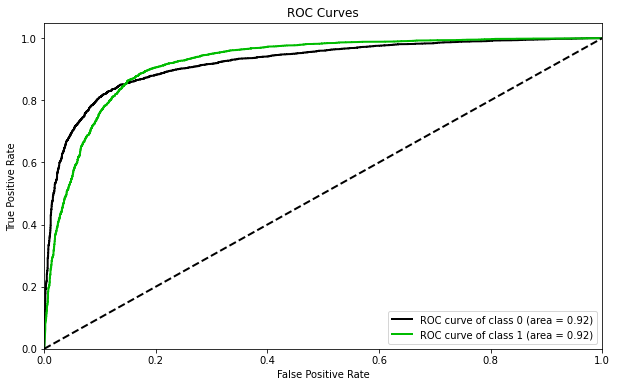

In [150]:
# Building Naive Bayes Classifier

NB_model = BernoulliNB()
NB = NB_model.fit(Train_X, Train_Y)
pred = NB.predict(Test_X)
pred_prob = NB.predict_proba(Test_X)
Classification_Summary(pred,pred_prob,3)

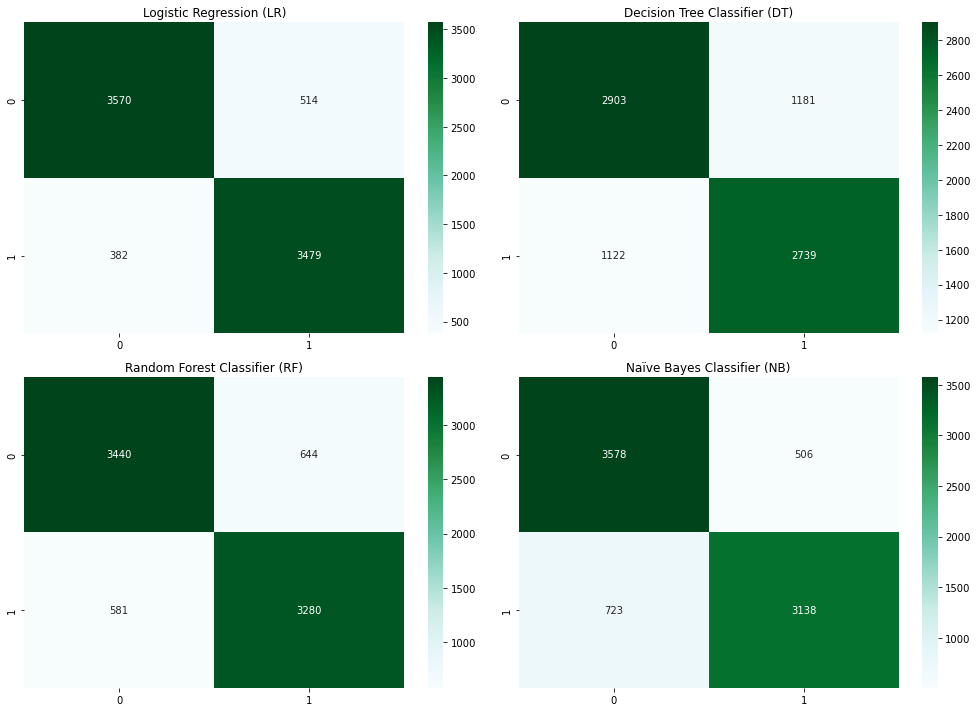

In [151]:
#Plotting Confusion-Matrix of all the predictive Models

labels=['Positive','Negative']
def plot_cm(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.columns=labels
    cm.index=labels
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    #fig, ax = plt.subplots()
    sns.heatmap(cm, annot=annot, fmt='')# cmap= "GnBu"
    
def conf_mat_plot(all_models):
    plt.figure(figsize=[14,5*math.ceil(len([all_models])*len(labels))])
    
    for i in range(len(all_models)):
        if len(labels)<=4:
            plt.subplot(2,2,i+1)
        else:
            plt.subplot(math.ceil(len(all_models)/2),2,i+1)
        pred = all_models[i].predict(Test_X)
        #plot_cm(Test_Y, pred)
        sns.heatmap(confusion_matrix(Test_Y, pred), annot=True, cmap='BuGn', fmt='.0f') #vmin=0,vmax=5
        plt.title(Evaluation_Results.index[i])
    plt.tight_layout()
    plt.show()

conf_mat_plot([LR,DT,RF,NB])

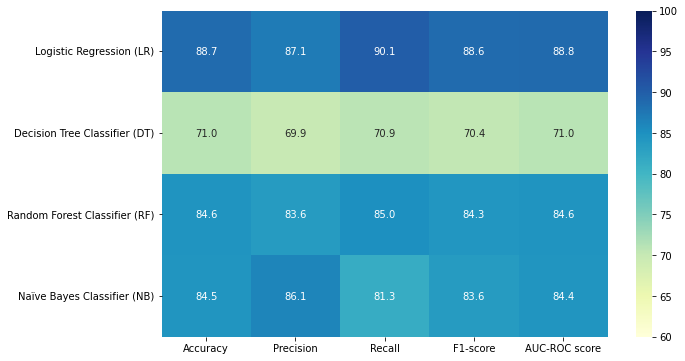

In [152]:
#Comparing all the models Scores

#plt.figure(figsize=[12,5])
sns.heatmap(Evaluation_Results, annot=True, vmin=60, vmax=100.0, cmap='YlGnBu', fmt='.1f')
plt.show()

## Save the best model


In [153]:
pickle.dump(LR,open('models/best_model_2.pkl','wb'))

# Alternatives tokenization

In [169]:
# load the processed data again


df = pd.read_csv('postprocessdata.csv')
df.head()

,text,label
0,grew b 1965 watch love thunderbird mate school...,0
1,put movi dvd player sat coke chip expect hope ...,0
2,whi peopl know particular time past like feel ...,0
3,even though great interest biblic movi bore de...,0
4,im die hard dad armi fan noth ever chang got t...,1


In [170]:
X = df.text
y = df.label

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

# Bag of Words

In [171]:
vect = CountVectorizer(max_features = 11000)


X_train_dm = vect.fit_transform(X_train)
X_test_dm = vect.transform(X_test)

In [172]:
X_train_dm.shape

(31778, 11000)

In [173]:
classifier = MultinomialNB()
classifier.fit(X_train_dm,y_train)

MultinomialNB()

In [174]:
predictions = classifier.predict(X_test_dm)

In [175]:
def evaluate_performance(y_true,predictions):
    #accuracy_score
    print(f"Accuracy : {accuracy_score(y_true,predictions,normalize=True) * 100} \n")
    
    #confusion matrix
    cm = confusion_matrix(y_true,predictions)
    ax = sns.heatmap(cm/np.sum(cm),fmt='.2%',annot=True,cmap='Blues')
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')

    ax.xaxis.set_ticklabels(['Negative','Positive'])
    ax.yaxis.set_ticklabels(['Negative','Positive'])
    plt.show();
    
    print('\n')
    #classification_report
    print(f"Classification report : \n{classification_report(y_true,predictions,target_names=['Negative','Positive'])}")

Accuracy : 84.88357457520453 



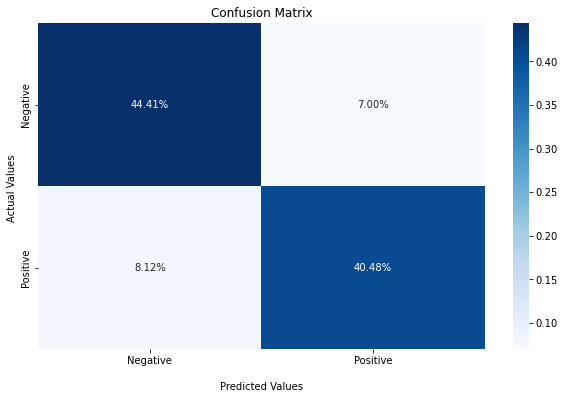



Classification report : 
              precision    recall  f1-score   support

    Negative       0.85      0.86      0.85      4084
    Positive       0.85      0.83      0.84      3861

    accuracy                           0.85      7945
   macro avg       0.85      0.85      0.85      7945
weighted avg       0.85      0.85      0.85      7945



In [176]:
evaluate_performance(y_test,predictions)

In [177]:
X_train.shape

(31778,)

In [178]:
statement = "The movie was totally boring. The story was dull and the editor did a horrible job at editing this movie. Should have left the jumps and scares instead of cutting it off when the time came."
st_dm = vect.transform([statement])
classifier.predict(st_dm)[0]

0

Accuracy : 87.17432347388294 



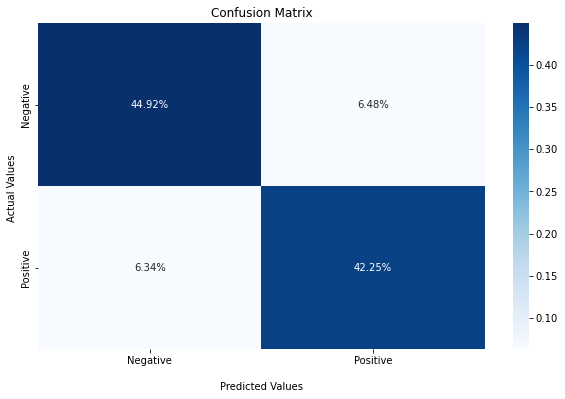



Classification report : 
              precision    recall  f1-score   support

    Negative       0.88      0.87      0.88      4084
    Positive       0.87      0.87      0.87      3861

    accuracy                           0.87      7945
   macro avg       0.87      0.87      0.87      7945
weighted avg       0.87      0.87      0.87      7945



In [179]:
logreg_classifier = LogisticRegression(class_weight='balanced',solver='liblinear')
logreg_classifier.fit(X_train_dm,y_train)
predictions = logreg_classifier.predict(X_test_dm)
evaluate_performance(y_test,predictions)

In [180]:
pickle.dump(logreg_classifier,open('models/log_model_final.pkl','wb'))

Accuracy : 84.27942101950913 



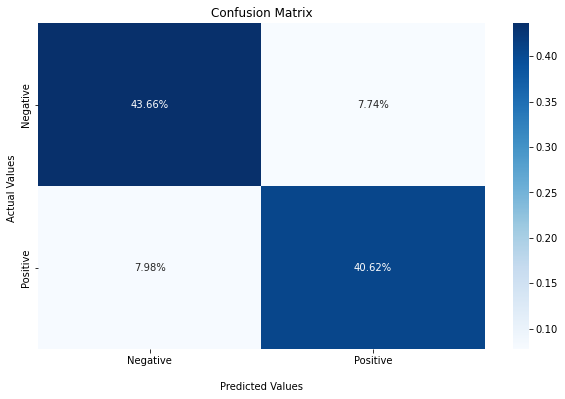



Classification report : 
              precision    recall  f1-score   support

    Negative       0.85      0.85      0.85      4084
    Positive       0.84      0.84      0.84      3861

    accuracy                           0.84      7945
   macro avg       0.84      0.84      0.84      7945
weighted avg       0.84      0.84      0.84      7945



In [181]:
vect = CountVectorizer(max_features = 11000)

X_train_dm = vect.fit_transform(X_train)
X_test_dm = vect.transform(X_test)

svm_classifier = LinearSVC()
svm_classifier.fit(X_train_dm,y_train)
predictions = svm_classifier.predict(X_test_dm)
evaluate_performance(y_test,predictions)

In [182]:
pickle.dump(vect,open('models/bagg_word_final.pkl','wb'))
pickle.dump(svm_classifier,open('models/model_final.pkl','wb'))

In [183]:
statement = ""
st_dm = vect.transform([statement])
svm_classifier.predict(st_dm)[0]

0